# Connect Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

dataset_path ="/content/drive/MyDrive/Colab_Notebooks/museum/train_dataset"

print("Dataset path exists:", os.path.exists(dataset_path))
print("Folders inside dataset:", os.listdir(dataset_path) if os.path.exists(dataset_path) else "Path not found")

Dataset path exists: True
Folders inside dataset: ['13_dombri', '15_sedlo2', '12_sandyk1', '14_sedlo1', '16_kobiz_vaza_gobelen', '10_posuda_dlya_kumisa', '20_yarkiy_gobelen_ledi', '17_gobelen_ornament_alasha', '19_fancy_vaza', '21_mujchina_s_mechom', '30_senokos', '37_gobelen_shahmati', '26_berkutchi_s_ptichey', '39_loshadki_na_jaylau', '25_voylok_na_kruge_abstract', '28_shokan_sidit', '29_vesna_jaylau_zagatovka_productov', '22_jambyl', '36_gobelen_derevo', '27_turksib', '48_Mullashev_triptih', '4_saukele', '5_barashki_pasutsya', '50_Sydyhanov_verbludica', '45_Esirkeev_zvuki_kobiza', '41_Aytbayev_schaste', '3_chernaya_vaza', '2_tri_skulpturi_s_sharami', '0_verblyud_skulptura', '1_barashek', '40_Abishev_klich', '42_Ahmetov_kompoziciya_4', '24_dekorativniyi_vazi_vmeste', '43_Dosmogambetov_Suleymenov', '44_Esenbayev_Saule', '46_Jumabay_tri_mecha', '49_Prokopeva_Sulemenov', '6_vaza_otdelno', '7_halat', '8_cvetushaya_yablonya', '9_burdyuk_otdelno', '32_mujchina_s_gazetoy', '18_ukrasheniya',

In [ ]:
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        print(f"Class: {class_folder}, Images: {len(os.listdir(class_path))}")


Class: 13_dombri, Images: 161
Class: 15_sedlo2, Images: 63
Class: 12_sandyk1, Images: 63
Class: 14_sedlo1, Images: 83
Class: 16_kobiz_vaza_gobelen, Images: 107
Class: 10_posuda_dlya_kumisa, Images: 202
Class: 20_yarkiy_gobelen_ledi, Images: 135
Class: 17_gobelen_ornament_alasha, Images: 89
Class: 19_fancy_vaza, Images: 140
Class: 21_mujchina_s_mechom, Images: 100
Class: 30_senokos, Images: 78
Class: 37_gobelen_shahmati, Images: 165
Class: 26_berkutchi_s_ptichey, Images: 80
Class: 39_loshadki_na_jaylau, Images: 89
Class: 25_voylok_na_kruge_abstract, Images: 132
Class: 28_shokan_sidit, Images: 83
Class: 29_vesna_jaylau_zagatovka_productov, Images: 60
Class: 22_jambyl, Images: 89
Class: 36_gobelen_derevo, Images: 193
Class: 27_turksib, Images: 64
Class: 48_Mullashev_triptih, Images: 186
Class: 4_saukele, Images: 70
Class: 5_barashki_pasutsya, Images: 84
Class: 50_Sydyhanov_verbludica, Images: 135
Class: 45_Esirkeev_zvuki_kobiza, Images: 146
Class: 41_Aytbayev_schaste, Images: 157
Class: 3

# VGG16 -- final_ver

In [ ]:
import os
import random
import shutil
import tensorflow as tf
import numpy as np
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import layers, models, regularizers
from keras.optimizers import Adam
from keras.applications.efficientnet import preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Параметры
batch_size = 32
img_size = (224, 224)
epochs = 20
data_path ="/content/drive/MyDrive/Colab_Notebooks/museum/train_dataset"

# Проверка и балансировка классов
class_counts = {}
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Cортируем классы
sorted_classes = sorted(class_counts.items(), key=lambda x: int(x[0].split("_")[0]))

print("Распределение классов:")
for class_name, count in sorted_classes:
    print(f"{class_name}: {count}")

# Генератор данных с усиленной аугментацией (убран random_cutout)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

# Количество классов
num_classes = len(train_generator.class_indices)

# Получаем уникальные классы из train_generator
label_encoder = LabelEncoder()

# Модель VGG16
base_model = VGG16(include_top=False, input_shape=(img_size[0], img_size[1], 3), weights='imagenet')
base_model.trainable = True

# Размораживаем только верхние 50 слоёв
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Построение модели
model = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.8),  # Повышенный Dropout для борьбы с переобучением
    layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))  # L2-регуляризация
])

# Компиляция модели с Label Smoothing и уменьшенным LR
model.compile(
    optimizer=Adam(learning_rate=2e-4),  # Начальный LR = 2e-4
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Label Smoothing 0.1
    metrics=['accuracy']
)

# Callback для динамического уменьшения Learning Rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# Обучение модели с балансировкой классов
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Классы и индексы
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

# Инвертируем словарь
inverted_class_indices = {v: k for k, v in class_indices.items()}

# Сохранение модели
model.save("exhibit_recognition_model_vgg16_10-epoches-49class.keras")

#--------------------------------------------------------------------------------------------
# Конвертация модели в TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Сохранение TFLite модели
tflite_model_path = "/content/drive/MyDrive/Colab_Notebooks/museum/train_dataset/vgg16_20_epochs_test.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Модель успешно сохранена в формате TFLite: {tflite_model_path}")

# Вычисление метрик на валидационном наборе
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix (нормализованная)
cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix Normalized")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# Precision, Recall, F1-score
report = classification_report(y_true, y_pred, target_names=list(class_indices.keys()))
print(report)

# F1-Confidence Curve
confidence_levels = np.linspace(0, 1, 100)
f1_scores = []

for conf in confidence_levels:
    filtered_preds = np.where(y_pred_probs.max(axis=1) >= conf, y_pred, -1)
    f1 = f1_score(y_true, filtered_preds, average='macro', zero_division=0)
    f1_scores.append(f1)

plt.figure(figsize=(8, 6))
plt.plot(confidence_levels, f1_scores, label=f'F1-score (max {max(f1_scores):.2f} at {confidence_levels[np.argmax(f1_scores)]:.3f})', color='blue')
plt.xlabel("Confidence")
plt.ylabel("F1-score")
plt.title("F1-Confidence Curve")
plt.legend()
plt.show()

# Mean Average Precision at IoU=0.5 и IoU=0.5:0.95
average_precisions = []
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])
    ap = average_precision_score(y_true == i, y_pred_probs[:, i])
    average_precisions.append(ap)

map_50 = np.mean(average_precisions)
map_50_95 = np.mean([ap for ap in average_precisions if ap > 0.05])  # Исключаем слишком малые значения

print(f"Mean Average Precision at IoU=0.5: {map_50:.4f}")
print(f"Mean Average Precision at IoU=0.5:0.95: {map_50_95:.4f}")


Распределение классов:
0_verblyud_skulptura: 171
1_barashek: 189
2_tri_skulpturi_s_sharami: 202
3_chernaya_vaza: 185
4_saukele: 124
5_barashki_pasutsya: 142
6_vaza_otdelno: 78
7_halat: 110
8_cvetushaya_yablonya: 40
9_burdyuk_otdelno: 107
10_posuda_dlya_kumisa: 202
12_sandyk1: 116
13_dombri: 197
14_sedlo1: 140
15_sedlo2: 114
16_kobiz_vaza_gobelen: 170
17_gobelen_ornament_alasha: 150
18_ukrasheniya: 164
19_fancy_vaza: 193
20_yarkiy_gobelen_ledi: 185
21_mujchina_s_mechom: 159
22_jambyl: 150
23_revolyuchiya_v_aule: 105
24_dekorativniyi_vazi_vmeste: 201
25_voylok_na_kruge_abstract: 190
26_berkutchi_s_ptichey: 136
27_turksib: 113
28_shokan_sidit: 141
29_vesna_jaylau_zagatovka_productov: 109
30_senokos: 136
31_gori_i_voda: 98
32_mujchina_s_gazetoy: 107
33_medeu: 105
34_ges: 109
35_vitrina_s_ukrasheniyami: 110
36_gobelen_derevo: 202
37_gobelen_shahmati: 200
38_gobelen_krasniy: 111
39_loshadki_na_jaylau: 148
40_Abishev_klich: 177
41_Aytbayev_schaste: 198
42_Ahmetov_kompoziciya_4: 194
43_Dosmoga

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 2623s 13s/step - accuracy: 0.0271 - loss: 4.6790 - val_accuracy: 0.0518 - val_loss: 4.2071 - learning_rate: 2.0000e-04
Epoch 2/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.0479 - loss: 4.0714 - val_accuracy: 0.0644 - val_loss: 3.7250 - learning_rate: 2.0000e-04
Epoch 3/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.0614 - loss: 3.7359 - val_accuracy: 0.1102 - val_loss: 3.3813 - learning_rate: 2.0000e-04
Epoch 4/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.1300 - loss: 3.2668 - val_accuracy: 0.1573 - val_loss: 2.9087 - learning_rate: 2.0000e-04
Epoch 5/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 191s 993ms/step - accuracy: 0.2189 - loss: 2.7708 - val_accuracy: 0.3650 - val_loss: 2.2294 - learning_rate: 2.0000e-04
Epoch 6/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 192s 998ms/step - accuracy: 0.3872 - loss: 2.2243 - val_accuracy: 0.6191 - val_loss: 1.8517 - learning_rate: 2.0000e-04
Epoch 7/20
192/192 ━━━━━━━━━━━━━━━━━━━━ 190s 991ms

NameError: name 'plt' is not defined

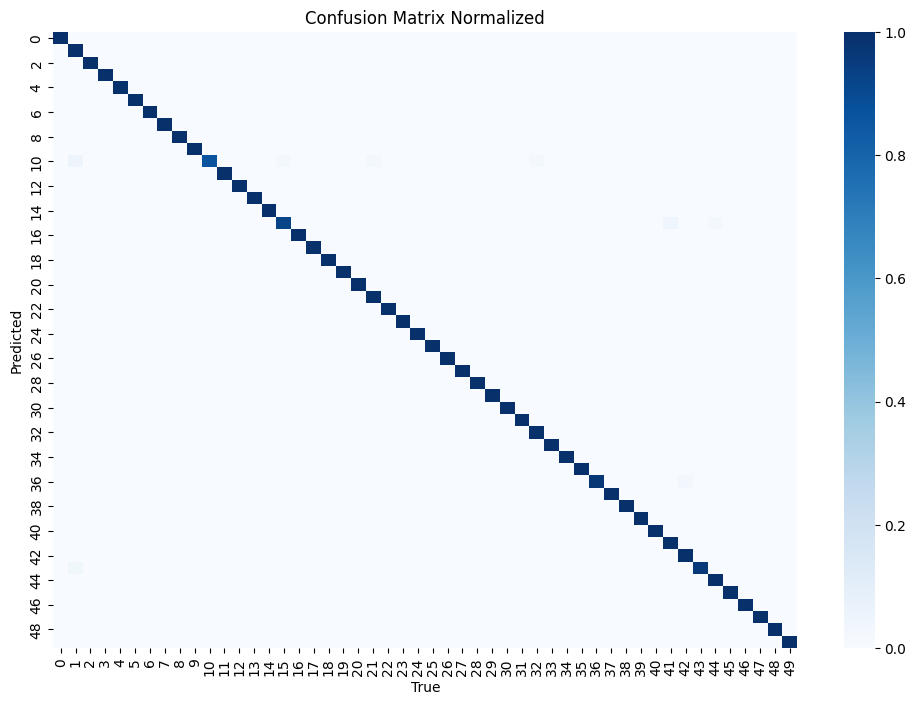

                                     precision    recall  f1-score   support

               0_verblyud_skulptura       1.00      1.00      1.00        34
              10_posuda_dlya_kumisa       0.93      1.00      0.96        40
                         12_sandyk1       1.00      1.00      1.00        23
                          13_dombri       1.00      1.00      1.00        39
                          14_sedlo1       1.00      1.00      1.00        28
                          15_sedlo2       1.00      1.00      1.00        22
              16_kobiz_vaza_gobelen       1.00      1.00      1.00        34
         17_gobelen_ornament_alasha       1.00      1.00      1.00        30
                     18_ukrasheniya       1.00      1.00      1.00        32
                      19_fancy_vaza       1.00      1.00      1.00        38
                         1_barashek       1.00      0.86      0.93        37
             20_yarkiy_gobelen_ledi       1.00      1.00      1.00        3

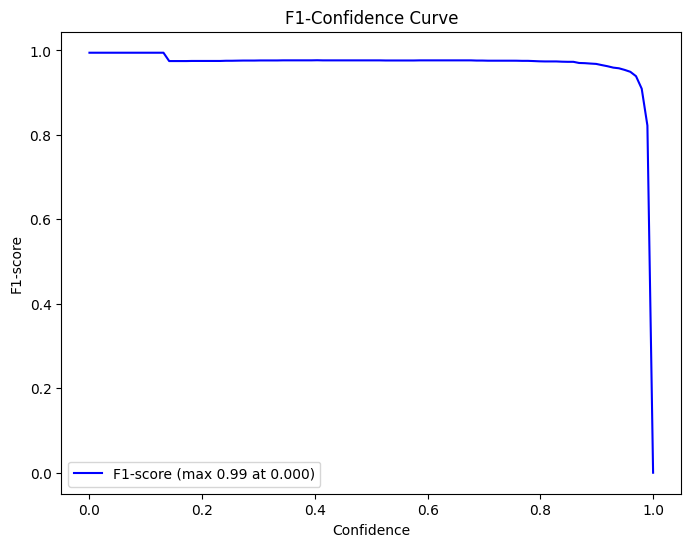

Mean Average Precision at IoU=0.5: 0.9993
Mean Average Precision at IoU=0.5:0.95: 0.9993


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix (нормализованная)
cm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix Normalized")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# Precision, Recall, F1-score
report = classification_report(y_true, y_pred, target_names=list(class_indices.keys()))
print(report)

# F1-Confidence Curve
confidence_levels = np.linspace(0, 1, 100)
f1_scores = []

for conf in confidence_levels:
    filtered_preds = np.where(y_pred_probs.max(axis=1) >= conf, y_pred, -1)
    f1 = f1_score(y_true, filtered_preds, average='macro', zero_division=0)
    f1_scores.append(f1)

plt.figure(figsize=(8, 6))
plt.plot(confidence_levels, f1_scores, label=f'F1-score (max {max(f1_scores):.2f} at {confidence_levels[np.argmax(f1_scores)]:.3f})', color='blue')
plt.xlabel("Confidence")
plt.ylabel("F1-score")
plt.title("F1-Confidence Curve")
plt.legend()
plt.show()

# Mean Average Precision at IoU=0.5 и IoU=0.5:0.95
average_precisions = []
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])
    ap = average_precision_score(y_true == i, y_pred_probs[:, i])
    average_precisions.append(ap)

map_50 = np.mean(average_precisions)
map_50_95 = np.mean([ap for ap in average_precisions if ap > 0.05])  # Исключаем слишком малые значения

print(f"Mean Average Precision at IoU=0.5: {map_50:.4f}")
print(f"Mean Average Precision at IoU=0.5:0.95: {map_50_95:.4f}")

In [ ]:
# Предобработка изображения
def preprocess_image(image_path):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Проход по всем изображениям в папке
image_folder = "/content/drive/MyDrive/Colab_Notebooks/museum/train_dataset/7_halat"
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

for image_path in image_files:
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class = inverted_class_indices.get(predicted_class_index, "Unknown")
    print(f"Изображение: {image_path} | Предсказанный класс: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Изображение: /content/drive/MyDrive/Colab_Notebooks/museum/train_dataset/7_halat/7_105_crop_0.jpg | Предсказанный класс: 7_halat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Изображение: /content/drive/MyDrive/Colab_Notebooks/museum/train_dataset/7_halat/7_112_crop_0.jpg | Предсказанный класс: 7_halat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Изображение: /content/drive/MyDrive/Colab_Notebooks/museum/train_dataset/7_halat/7_119_crop_0.jpg | Предсказанный класс: 7_halat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Изображение: /content/drive/MyDrive/Colab_Notebooks/museum/train_dataset/7_halat/7_0_crop_0.jpg | Предсказанный класс: 13_dombri
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Изображение: /content/drive/MyDrive/Colab_Notebooks/museum/train_dataset/7_halat/7_133_crop_0.jpg | Предсказанный класс: 7_halat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Изображение: /content/drive/MyDrive/Colab_Notebooks/museum/train_dataset/7_halat/7_124_crop_0.jpg | Предсказанный класс: 7_halat


In [ ]:
from keras.preprocessing import image
import numpy as np

# Load a new exhibit image to test
img_path ="/content/drive/MyDrive/Colab_Notebooks/museum/val/chernaya_vaza/3_1_25.jpg"

img = image.load_img(img_path, target_size=(224, 224))  # Resize to match input size of the model
x = image.img_to_array(img)  # Convert image to array
x = np.expand_dims(x, axis=0)  # Add batch dimension
x = preprocess_input(x)  # Preprocess the image for your model

# Make a prediction
predictions = model.predict(x)

# Decode predictions (if you have class labels)
predicted_class = np.argmax(predictions, axis=1)
print("Predicted Class:", predicted_class)